<a href="https://colab.research.google.com/github/dineshnaiduavula/MOUnderUncertainity_Assignment/blob/main/MOUncertainitydinesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

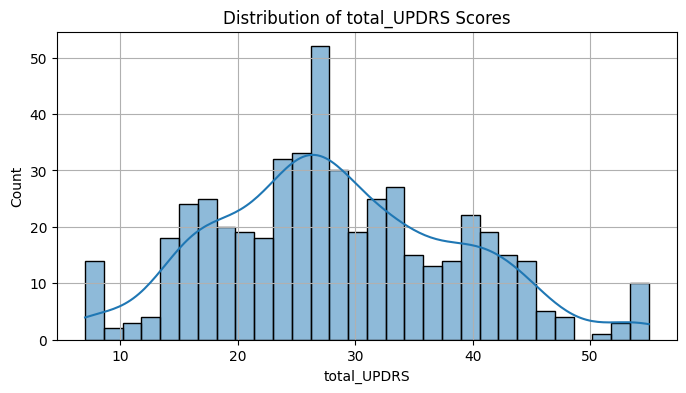

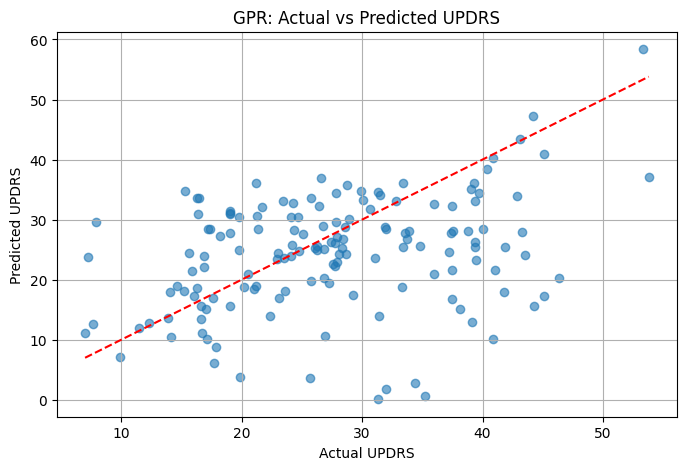

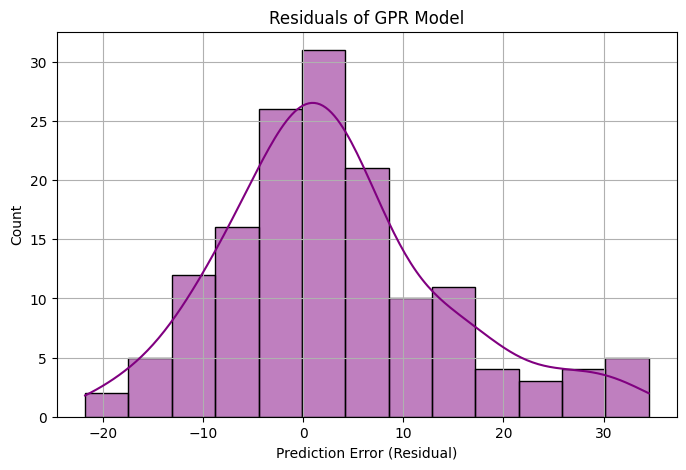

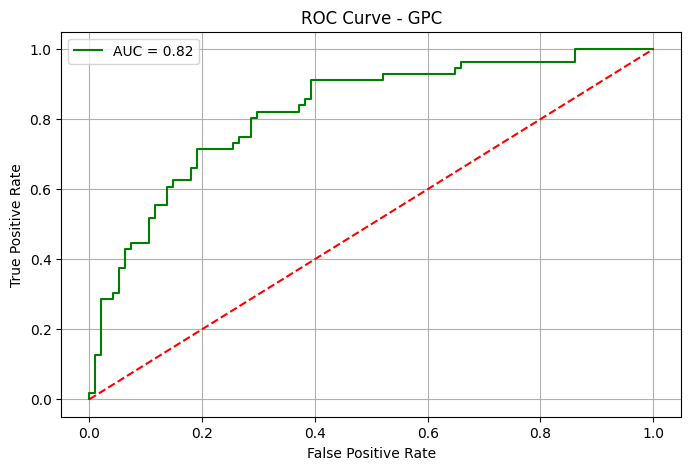

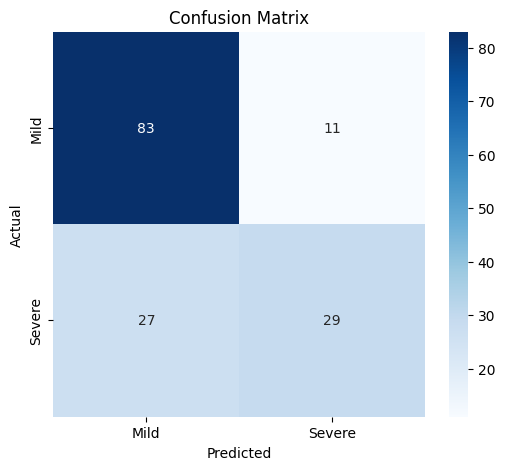

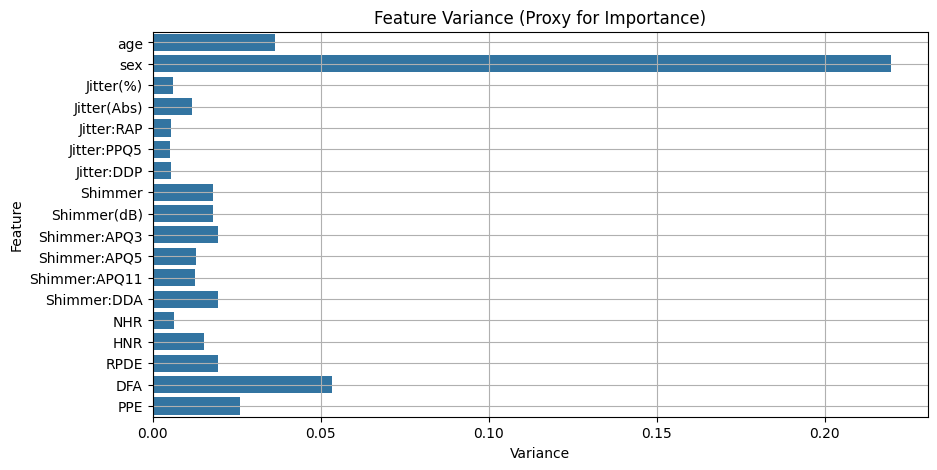

Regression RMSE: 11.58
Regression R² Score: -0.37
Classification Accuracy: 0.75
Classification ROC AUC: 0.82


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# Load data
dataset_url = "https://raw.githubusercontent.com/dineshnaiduavula/MOUnderUncertainity_Assignment/refs/heads/main/parkinsons_updrs.data"
df_parkinsons = pd.read_csv(dataset_url, sep=',')

# Clean dataset
df_parkinsons = df_parkinsons.drop(columns=['subject#', 'test_time'])
df_parkinsons = df_parkinsons.sample(n=500, random_state=42).reset_index(drop=True)

# Histogram of UPDRS scores
plt.figure(figsize=(8, 4))
sns.histplot(df_parkinsons['total_UPDRS'], bins=30, kde=True)
plt.title("Distribution of total_UPDRS Scores")
plt.xlabel("total_UPDRS")
plt.grid()
plt.show()

# Normalize features
scaler_normalizer = MinMaxScaler()
features = df_parkinsons.drop(columns=['total_UPDRS', 'motor_UPDRS'])
features_scaled = scaler_normalizer.fit_transform(features)

# Define targets
target_regression = df_parkinsons['total_UPDRS']
target_classification = (target_regression > 30).astype(int)

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features_scaled, target_regression, test_size=0.3, random_state=42)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(features_scaled, target_classification, test_size=0.3, random_state=42)

# Gaussian Process Regression
model_gpr = GaussianProcessRegressor(kernel=RBF(), alpha=0.1)
model_gpr.fit(X_train_reg, y_train_reg)
predictions_reg = model_gpr.predict(X_test_reg)

# Regression evaluation
rmse_value = np.sqrt(mean_squared_error(y_test_reg, predictions_reg))
r2_value = r2_score(y_test_reg, predictions_reg)

# Regression: Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test_reg, predictions_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel("Actual UPDRS")
plt.ylabel("Predicted UPDRS")
plt.title("GPR: Actual vs Predicted UPDRS")
plt.grid()
plt.show()

# Residuals Plot
residual_errors = y_test_reg - predictions_reg
plt.figure(figsize=(8, 5))
sns.histplot(residual_errors, kde=True, color="purple")
plt.title("Residuals of GPR Model")
plt.xlabel("Prediction Error (Residual)")
plt.grid()
plt.show()

# Gaussian Process Classification
model_gpc = GaussianProcessClassifier(kernel=RBF(), max_iter_predict=100)
model_gpc.fit(X_train_cls, y_train_cls)
predictions_cls = model_gpc.predict(X_test_cls)
probabilities_cls = model_gpc.predict_proba(X_test_cls)[:, 1]

# Classification evaluation
classification_accuracy = accuracy_score(y_test_cls, predictions_cls)
classification_auc = roc_auc_score(y_test_cls, probabilities_cls)
conf_matrix = confusion_matrix(y_test_cls, predictions_cls)

# ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_test_cls, probabilities_cls)
plt.figure(figsize=(8, 5))
plt.plot(fpr_vals, tpr_vals, label="AUC = " + str(round(classification_auc, 2)), color="green")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GPC")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix (heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Mild", "Severe"], yticklabels=["Mild", "Severe"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Feature Variance (proxy for importance)
feature_variance = np.var(features_scaled, axis=0)
feature_labels = df_parkinsons.drop(columns=['total_UPDRS', 'motor_UPDRS']).columns

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_variance, y=feature_labels)
plt.title("Feature Variance (Proxy for Importance)")
plt.xlabel("Variance")
plt.ylabel("Feature")
plt.grid()
plt.show()

# Summary
print("Regression RMSE:", round(rmse_value, 2))
print("Regression R² Score:", round(r2_value, 2))
print("Classification Accuracy:", round(classification_accuracy, 2))
print("Classification ROC AUC:", round(classification_auc, 2))


